In [ ]:
# Install dependencies required
!pip install torchvision


In [ ]:
%pip install torchsummary

In [ ]:
!torchvision --version

/bin/bash: torchvision: command not found


In [ ]:
import torchvision
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
import PIL.Image as Image
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [ ]:
# Library for accessing google drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
data_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET"
train_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET/DATA_TRAINING"
valid_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET/DATA_VALID"
diseases = os.listdir(train_dir)

In [ ]:
# Define our classes first
__classes =['Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy']
__classes

In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

In [ ]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [ ]:
# check our train shape
img, label = train[0]
print(img.shape, label)

In [ ]:
# total number of classes in train set
len(train.classes)

In [ ]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
# setting the batch size
batch_size = 32

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [ ]:
torch.cuda.is_available()

In [ ]:
# Let's CHeck device
torch.device(2)

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Try to check our device
device = get_default_device()
device

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [ ]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

In [ ]:
model = torch.load('/content/drive/MyDrive/TA-GROUP11/Model/plant-disease-model-complete5.pth')
model.eval()

## Visualize Convolution Layer

In [ ]:
import torch.optim as optim 
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
print(model.__dict__)

{'training': False, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': OrderedDict([('conv1', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)), ('conv2', Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
)), ('res1', Sequential(
  (0): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2

In [ ]:
def visuals_prediction(img, activation_model):
    """ visuals first layer activation and activation along side the modeling
    """

    # run model in predict mode
    activations = activation_model(img) # Returns a list of five Numpy arrays: one array per layer activation
    first_layer_activation = activations[0]
    plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
    layer_names = []
    for layer in model.layers[:9]:
        layer_names.append(layer.name)

    images_per_row = 24

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name, fontsize=20)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
    return

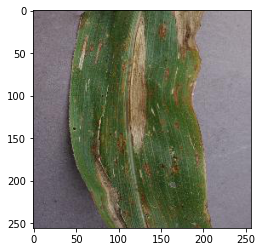

In [ ]:
img = Image.open('/content/drive/MyDrive/TA-GROUP11/DATASET/DATA_TESTING/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG')
plt.imshow(img)

## Space


In [ ]:
# img = Image.open('/content/drive/MyDrive/TA-GROUP11/DATASET/DATA_TESTING/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG')

In [ ]:
# tfms = transforms.Compose([
#         transforms.Resize([256,256]),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# unsqueeze provides the batch dimension
# img_tensor = tfms(img).to('cuda').unsqueeze(0)

In [ ]:
# prediction = model(img_reshape)

In [ ]:
test_dir = '/content/drive/MyDrive/TA-GROUP11/DATASET'
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir +'/DATA_TESTING' )) # since images in test folder are in alphabetical order

In [ ]:
def predict_image(img, model):
  """Converts image to array and return the predicted class
      with highest probability"""
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  _,preds =  torch.max(yb,dim=1)
  percentage = torch.nn.functional.softmax(yb, dim=1)[0] * 100
  #
  # Print the name along with score of the object identified by the model
  #
  labels = __classes
  print(labels[preds[0]], round(percentage[preds[0]].item(),2))
  #
  # Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.
  #
  _, indices = torch.sort(yb, descending=True)
  result = [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]
  return labels[preds[0]], round(percentage[preds[0]].item(),2);

In [ ]:
import pandas as pd
#Creating a confusion matrix
from sklearn.metrics import confusion_matrix
cm_lists = list()
def confusionMatrix(nb_classes):
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  # cm_df = pd.Dataframe()
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(valid_dl):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

          # print(confusion_matrix)
          # get the per-class accuracy:
          # print((confusion_matrix.diag()/confusion_matrix.sum(1)).tolist())
          # cm_df.append(pd.Dataframe(list(confusion_matrix.diag()/confusion_matrix.sum(1)),ignore_index = True))
          cm_lists.append((confusion_matrix.diag()/confusion_matrix.sum(1)).tolist())
  # cm_df = pd.DataFrame(cm_lists, columns=__classes)
  return confusion_matrix.tolist()

In [ ]:
cm = confusionMatrix(4)
cm = np.array(cm, dtype=np.float32)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm
# cm_lists = confusionMatrix(4)
# cm_lists

array([[0.95609756, 0.        , 0.04390244, 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.02096436, 0.00209644, 0.97484277, 0.00209644],
       [0.        , 0.        , 0.00209644, 0.99790356]])

In [ ]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=__classes, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:.2f})%'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/TA-GROUP11/ConfusionMatrix/' + file_name)

    return

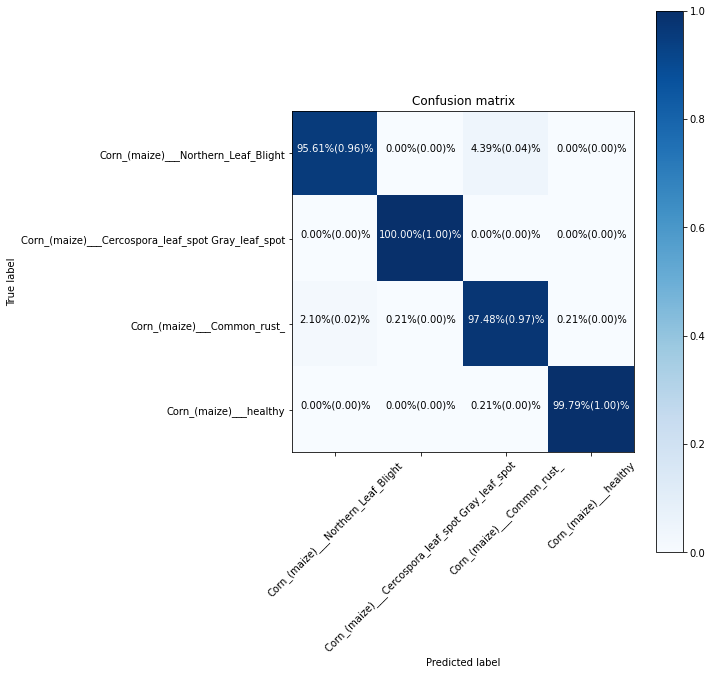

In [ ]:
plot_confusion_matrix(cm)

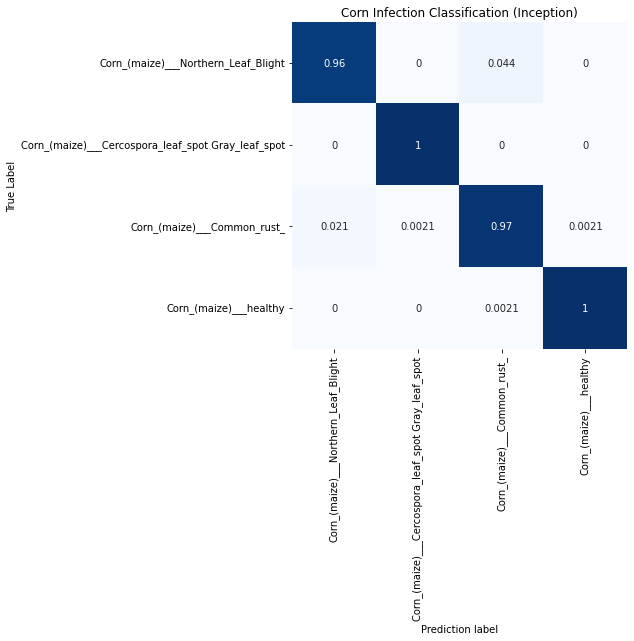

In [ ]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from itertools import cycle

#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = __classes,
                     columns = __classes
                    )


plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Blues',cbar=False)
plt.title('Corn Infection Classification (Inception)')
plt.ylabel('True Label')
plt.xlabel('Prediction label')
plt.show()

In [ ]:
# Preprocessing cm_lists for make heatmap
import math
import numpy
def preproc(cm_lists):
  for ls in cm_lists:
    for i in range(len(ls)):
      if numpy.isnan(ls[i]):
        ls[i]=0
      elif ~numpy.isnan(ls[i]):
        ls[i] = float(round(ls[i],2))
def makeDF(cm_lists):
  mydct = dict()
  for i in range(len(__classes)):
    mydct[__classes[i]] = [l[i] for l in cm_lists]
  return pd.DataFrame.from_dict(mydct)
cm_df = makeDF(cm_lists)
cm_df.tail()

,Corn_(maize)___Northern_Leaf_Blight,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Common_rust_,Corn_(maize)___healthy
53,0.956098,1.0,0.974843,1.000000
54,0.956098,1.0,0.974843,1.000000
55,0.956098,1.0,0.974843,0.997727
56,0.956098,1.0,0.974843,0.997881
57,0.956098,1.0,0.974843,0.997904


In [ ]:
nb_classes = 4
print(confusionMatrix(nb_classes))

[[392.0, 0.0, 18.0, 0.0], [0.0, 465.0, 0.0, 0.0], [10.0, 1.0, 465.0, 1.0], [0.0, 0.0, 1.0, 476.0]]


<class 'torch.Tensor'>
Corn_(maize)___Common_rust_ 99.9071273803711
Label: 0a11f9e8-7357-48c2-8550-daeae59a1e76___RS_NLB 3588.JPG , Predicted: ('Corn_(maize)___Common_rust_', 99.9071273803711)


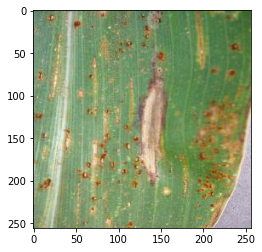

In [ ]:
# predicting first image
ti = 4
img, label = test[ti]
print(type(img))
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[ti], ', Predicted:', predict_image(img, model))

Saving 0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352_new30degFlipLR.JPG to 0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352_new30degFlipLR.JPG
RGB
Corn_(maize)___Northern_Leaf_Blight 99.99989318847656
Predict:  Corn_(maize)___Northern_Leaf_Blight Percentage : 99.99989318847656


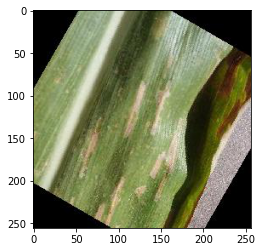

In [ ]:
from PIL import Image
from google.colab import files
import cv2
uploaded = files.upload()
label = str(list(uploaded.keys())[0])
path = '/content/' + label
def getFilenameFileExtension(path):
  longFileName,fileExtension = path.split('.',2)
  filename = [s for s in longFileName.split('/')][-1]
  return filename,fileExtension

# img = Image.open(path).convert('L').resize((28, 28), Image.ANTIALIAS)
img = Image.open(path)
if img.mode == 'RGBA':
  filename,fileextension = getFilenameFileExtension(path)
  img.load()
  background = Image.new("RGB", img.size, (255, 255, 255))
  background.paste(img, mask = img.split()[3])
  background.save(filename+'.'+'JPG', "JPEG", quality=100)
  print(background.mode)
  img = Image.open(filename+'.'+'JPG')
# Convert and reshape
print(img.mode)
img.convert('RGB')
img = img.resize((256, 256), Image.ANTIALIAS)


# img = np.array(img)

# Convert to tensor
# Define a transform to convert the image to tensor
transform = transforms.ToTensor()

# Convert the image to PyTorch tensor
img = transform(img)
predicted,percentage = predict_image(img,model)
print("Predict: ",predicted, "Percentage :",percentage)
plt.imshow(img.permute(1, 2, 0))

<class 'torch.Tensor'>
Corn_(maize)___healthy 100.0
Label: RS_Rust 1567.JPG , Predicted: ('Corn_(maize)___healthy', 100.0)


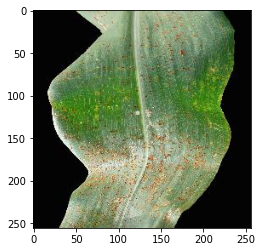

In [ ]:
# predicting first image
ti = 18
img, label = test[ti]
print(type(img))
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[ti], ', Predicted:', predict_image(img, model))

In [ ]:
print(enumerate(test))

In [ ]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
      print('Label: ', test_images[i], ', Predicted:', predict_image(img, model))

Corn_(maize)___Common_rust_ 99.92900848388672
Label:  00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG , Predicted: ('Corn_(maize)___Common_rust_', 99.92900848388672)
Corn_(maize)___Northern_Leaf_Blight 92.17604064941406
Label:  00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG , Predicted: ('Corn_(maize)___Northern_Leaf_Blight', 92.17604064941406)
Corn_(maize)___Common_rust_ 99.99959564208984
Label:  00a55069-3fa3-405b-8d87-4d3408a6ed98___RS_NLB 3645.JPG , Predicted: ('Corn_(maize)___Common_rust_', 99.99959564208984)
Corn_(maize)___Northern_Leaf_Blight 96.52896881103516
Label:  0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352.JPG , Predicted: ('Corn_(maize)___Northern_Leaf_Blight', 96.52896881103516)
Corn_(maize)___Common_rust_ 99.9071273803711
Label:  0a11f9e8-7357-48c2-8550-daeae59a1e76___RS_NLB 3588.JPG , Predicted: ('Corn_(maize)___Common_rust_', 99.9071273803711)
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 99.9789047241211
Label:  0a1a49a8-3a95-415a-b115-4d6

IndexError: ignored